# Packages

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statannotations.Annotator as statannotator
import statsmodels.formula.api as smf
import statsmodels.api as sm
import sys

# Appending python modules so we can run simulations
sys.path.append('../python')

import json_utilities
import model_utilities
from matplotlib.pyplot import figure
from pymunk.vec2d import Vec2d
from scipy import stats
from statannot import add_stat_annotation
from statsmodels.formula.api import ols
from statsmodels.iolib.smpickle import load_pickle

pygame 2.1.2 (SDL 2.0.18, Python 3.10.2)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [2]:
# Are we saving the cleaned data to a JSON?
saving_clean_data_to_dist = True
data_dir = '../data/cleaned_data'

In [7]:
# Are we saving figures?
saving_figures = True
figure_dir = '../paper/figures/src'

## Plotting parameters

In [9]:
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=1.4,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
    },
)


# Modeling

In [5]:
df_exp1 = pd.read_json('../data/cleaned_data/cleaned_data_exp1.json')

## Experiment 1

**Does response time trend with simulation time?** 

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

low vs. med: Mann-Whitney-Wilcoxon test two-sided, P_val:1.672e-44 U_stat=1.524e+05
med vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.624e-10 U_stat=1.993e+05
low vs. high: Mann-Whitney-Wilcoxon test two-sided, P_val:1.953e-89 U_stat=1.004e+05


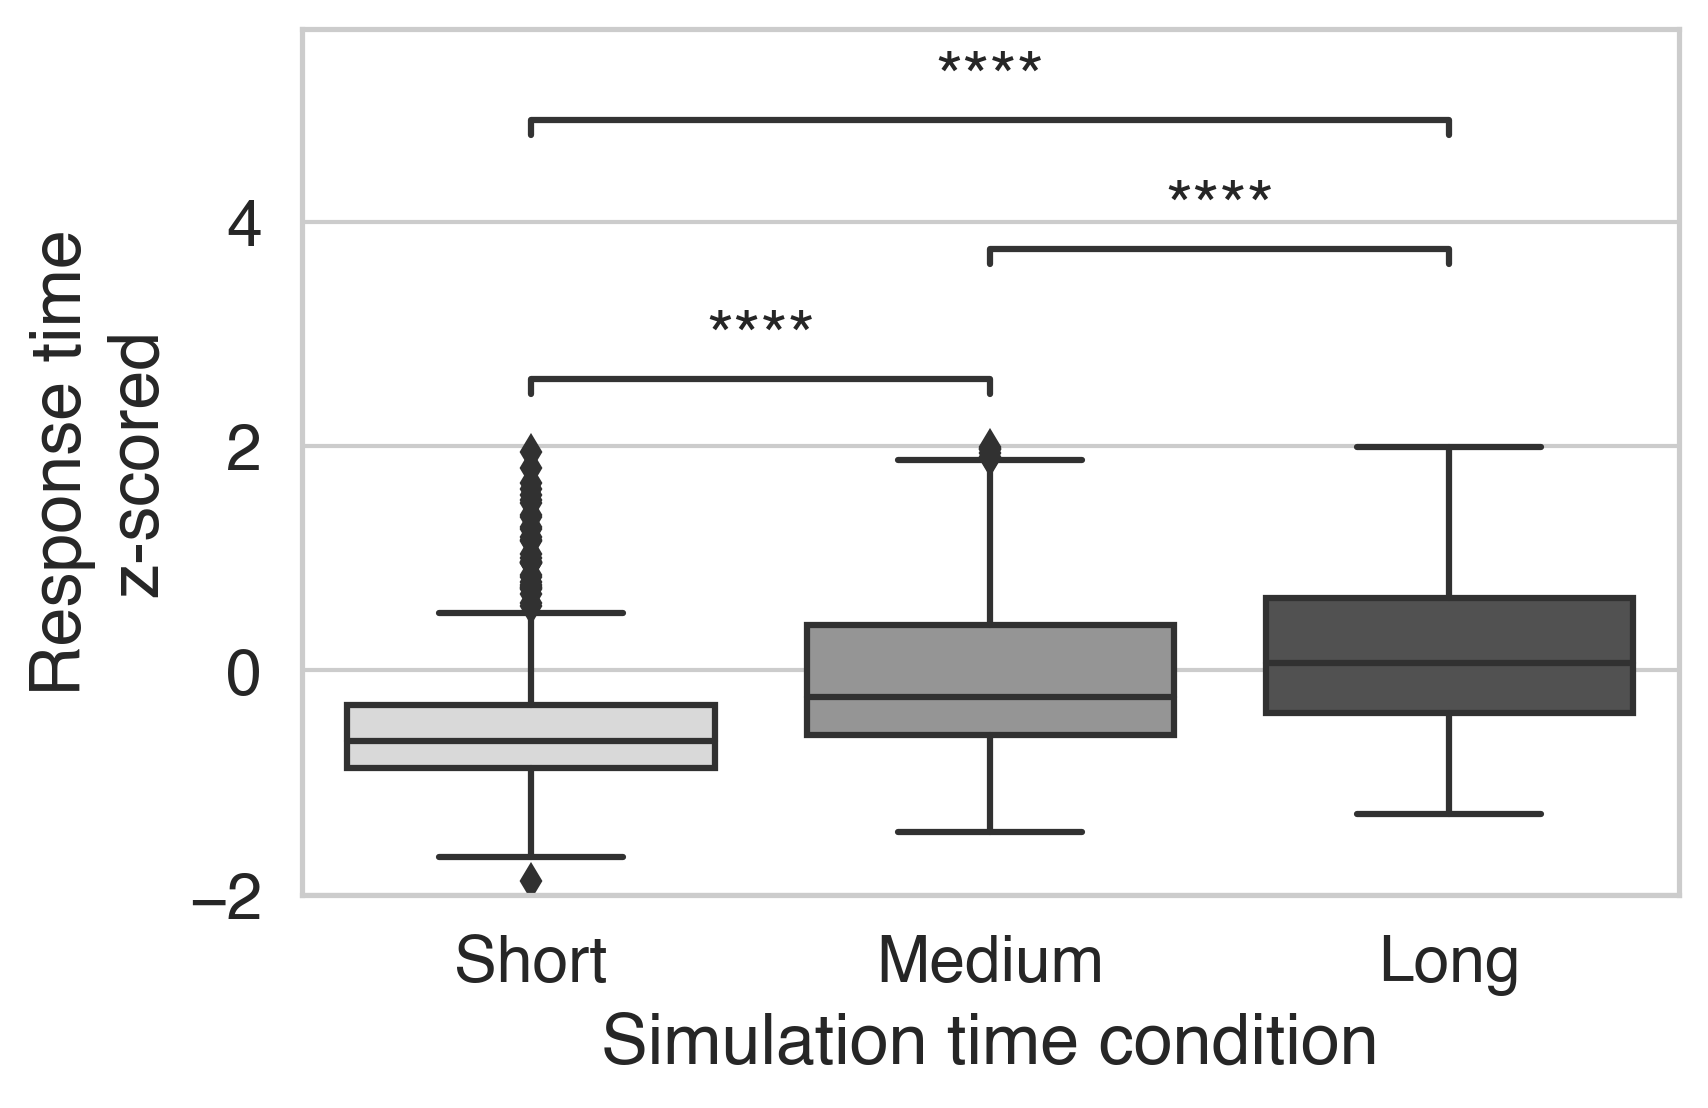

In [10]:
# Custom palette
custom_palette = ['#5FD372', '#31B346', '#279039']
# Independent variable
x = 'simulation_time_condition'
# Dependent variable
y = 'participant_z_rt'
order = ['low','med','high']

ax = sns.boxplot(data=df_exp1, x=x, y=y, order=order, palette="Greys")
# ax.axes.set_title('aa', pad=15)
ax.set_xlabel('Simulation time condition')
ax.set_ylabel('Response time\nz-scored')
ax.set(ylim=(-2,4.6))
ax.set(xticklabels=['Short', 'Medium', 'Long'])

pairs=[("low", "med"), ("med", "high"), ("low", "high")]
annotator = statannotator.Annotator(ax, pairs, data=df_exp1, x=x, y=y, order=order)
annotator.configure(test='Mann-Whitney', text_format='star')
annotator.apply_test()
ax, test_results = annotator.annotate()
plt.tight_layout()
if saving_figures:
    plt.savefig(f'{figure_dir}/exp1_results_a.pdf')

### Blended model parameters

In [9]:
# Directory with model fits
path_to_model_predictions = "../data/model_fits/model_fits_exp1.csv"
path_to_model_predictions = os.path.expanduser('~/Desktop/model_fit/model_fits.csv')

In [10]:
# Dataframe with model fits
model_df = pd.read_csv(path_to_model_predictions)

In [102]:
# Sort model parameters based on MSE
best_fitting_parameters = model_df[model_df['mse'] >= max(model_df['mse'])]
best_fitting_parameters_exp1 = best_fitting_parameters
best_fitting_parameters

,N,D,E,Noise,mse
264459,5,75,0.9,0.0,8.17879


In [103]:
# Grab the best fitting parameters
n = list(best_fitting_parameters['N'])[0]
d = list(best_fitting_parameters['D'])[0]
e = list(best_fitting_parameters['E'])[0]
noise = list(best_fitting_parameters['Noise'])[0]
n,d,e, noise

(5, 75, 0.9, 0.0)

In [104]:
# Path to jsons of scenes
path_to_scene_dir_exp1 = "../data/json/experiment1/"

In [105]:
# Gather JSON files of scenes from Experiment 1
scene_json_files_exp1 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp1) if pos_json.endswith('.json')]

In [106]:
# Model results
# Blended model
model_blended_results_exp1 = pd.DataFrame({})
# Pure simulation model
model_simulation_results_exp1 = pd.DataFrame({})
# Pure abstraction model
model_abstraction_results_exp1 = pd.DataFrame({})
# Number of samples to take from each model
samples = 50
# Set up inference models
blended_model_parameters = {
    'view': False,
    'noise': noise,
    'N': n,
    'D': d,
    'E': e,
}
abstraction_model_parameters = {
    'view': False,
    'noise': noise,
    'N': 1,
    'D': d,
    'E': 0.0,
}
simulation_model_parameters = {
    'view': False,
    'noise': 0.0,
}

#### Blended model

In [107]:
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    blended_model = model_utilities.BlendedModel(
        blended_model_parameters
    )
    df_blended_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        blended_model_sample = blended_model.sample(scene_model)
        blended_model_sample = blended_model_sample.model_dump()
        df_blended_model_sample = pd.DataFrame(blended_model_sample, index=[0])
        df_blended_model_output = pd.concat([df_blended_model_output, df_blended_model_sample])
    # Collect statistics from samples
    df_blended_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_blended_model_output['collision']),
         'simulation_time':df_blended_model_output['simulation_ticks'],
         'type':'blended_model'
        }
    )
    # Update results
    model_blended_results_exp1 = pd.concat([model_blended_results_exp1,df_blended_result])

#### Simulation model

In [108]:
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    for _ in range(samples):
        simulation_model_sample = simulation_model.sample(scene_model)
        simulation_model_sample = simulation_model_sample.model_dump()
        df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
        df_simulation_model_output = pd.concat([df_simulation_model_output, df_simulation_model_sample])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_output['collision']),
         'simulation_time':df_simulation_model_output['simulation_ticks'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp1 = pd.concat([model_simulation_results_exp1,df_simulation_result])

#### Abstraction model

In [109]:
for scene_file in scene_json_files_exp1:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp1, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    abstraction_model = model_utilities.BlendedModel(
        abstraction_model_parameters
    )
    df_abstraction_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        abstraction_model_sample = abstraction_model.sample(scene_model)
        abstraction_model_sample = abstraction_model_sample.model_dump()
        df_abstraction_model_sample = pd.DataFrame(abstraction_model_sample, index=[0])
        df_abstraction_model_output = pd.concat([df_abstraction_model_output, df_abstraction_model_sample])
    # Collect statistics from samples
    df_abstraction_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_abstraction_model_output['collision']),
         'simulation_time':df_abstraction_model_output['simulation_ticks'],
         'type':'blended_model'
        }
    )
    # Update results
    model_abstraction_results_exp1 = pd.concat([model_abstraction_results_exp1,df_abstraction_result])

In [110]:
model_blended_results_exp1['mean_simulation_time'] = model_blended_results_exp1.groupby('scene').simulation_time.transform(np.mean)
model_blended_results_exp1['mean_simulation_time_z'] = model_blended_results_exp1.mean_simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [111]:
model_simulation_results_exp1['mean_simulation_time'] = model_simulation_results_exp1.groupby('scene').simulation_time.transform(np.mean)
model_simulation_results_exp1['mean_simulation_time_z'] = model_simulation_results_exp1.mean_simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [112]:
model_abstraction_results_exp1['mean_simulation_time'] = model_abstraction_results_exp1.groupby('scene').simulation_time.transform(np.mean)
model_abstraction_results_exp1['mean_simulation_time_z'] = model_abstraction_results_exp1.mean_simulation_time.transform(lambda x: (x-x.mean())/x.std())

In [113]:
mean_rt_blended = pd.DataFrame(model_blended_results_exp1.groupby('scene').mean_simulation_time_z)
mean_rt_blended = mean_rt_blended.rename(columns = {0:'scene',1:'mean_rt_z_blended'})
mean_rt_blended.mean_rt_z_blended = mean_rt_blended.mean_rt_z_blended.transform(lambda x: list(x)[1])

In [114]:
mean_rt_simulation = pd.DataFrame(model_simulation_results_exp1.groupby('scene').mean_simulation_time_z)
mean_rt_simulation = mean_rt_simulation.rename(columns = {0:'scene',1:'mean_rt_z_simulation'})
mean_rt_simulation.mean_rt_z_simulation = mean_rt_simulation.mean_rt_z_simulation.transform(lambda x: list(x)[1])

In [115]:
mean_rt_abstraction = pd.DataFrame(model_abstraction_results_exp1.groupby('scene').mean_simulation_time_z)
mean_rt_abstraction = mean_rt_abstraction.rename(columns = {0:'scene',1:'mean_rt_z_abstraction'})
mean_rt_abstraction.mean_rt_z_abstraction = mean_rt_abstraction.mean_rt_z_abstraction.transform(lambda x: list(x)[1])

In [116]:
mean_rt_empirical = pd.DataFrame(df_exp1.groupby('scene').participant_z_rt.mean())
mean_rt_empirical = mean_rt_empirical.rename(columns = {0:'scene','participant_z_rt':'mean_rt_z_empirical'})
mean_rt_empirical = mean_rt_empirical.reset_index()

In [117]:
full_rt_empirical = df_exp1[['scene','participant_z_rt','subject_id']]

In [118]:
full_rt = full_rt_empirical.merge(mean_rt_simulation, on='scene')
full_rt = full_rt.merge(mean_rt_blended, on='scene')
mean_rt = full_rt.merge(mean_rt_abstraction, on='scene')
full_rt['path_condition'] = full_rt.scene.apply(lambda x: 'not_straight' if 'nosp' in x else 'straight')

In [119]:
mean_rt = mean_rt_empirical.merge(mean_rt_simulation, on='scene')
mean_rt = mean_rt.merge(mean_rt_blended, on='scene')
mean_rt = mean_rt.merge(mean_rt_abstraction, on='scene')
mean_rt['path_condition'] = mean_rt.scene.apply(lambda x: 'not_straight' if 'nosp' in x else 'straight')

In [120]:
# Formula for empirical data to blended model
emp_blended_formula = 'mean_rt_z_empirical ~ mean_rt_z_blended'

# Ordinary linear models based on path condition for empirical data
blended_model_predictions = smf.ols(
    emp_blended_formula,
    mean_rt
).fit()

# Parameters from both models
intercept = blended_model_predictions.params.Intercept
coefficient = blended_model_predictions.params.mean_rt_z_blended

mean_rt['mean_rt_z_blended_fit'] = mean_rt.mean_rt_z_blended.apply(lambda x: intercept + coefficient*x)

In [121]:
mean_rt = mean_rt[mean_rt.mean_rt_z_abstraction <= 3]

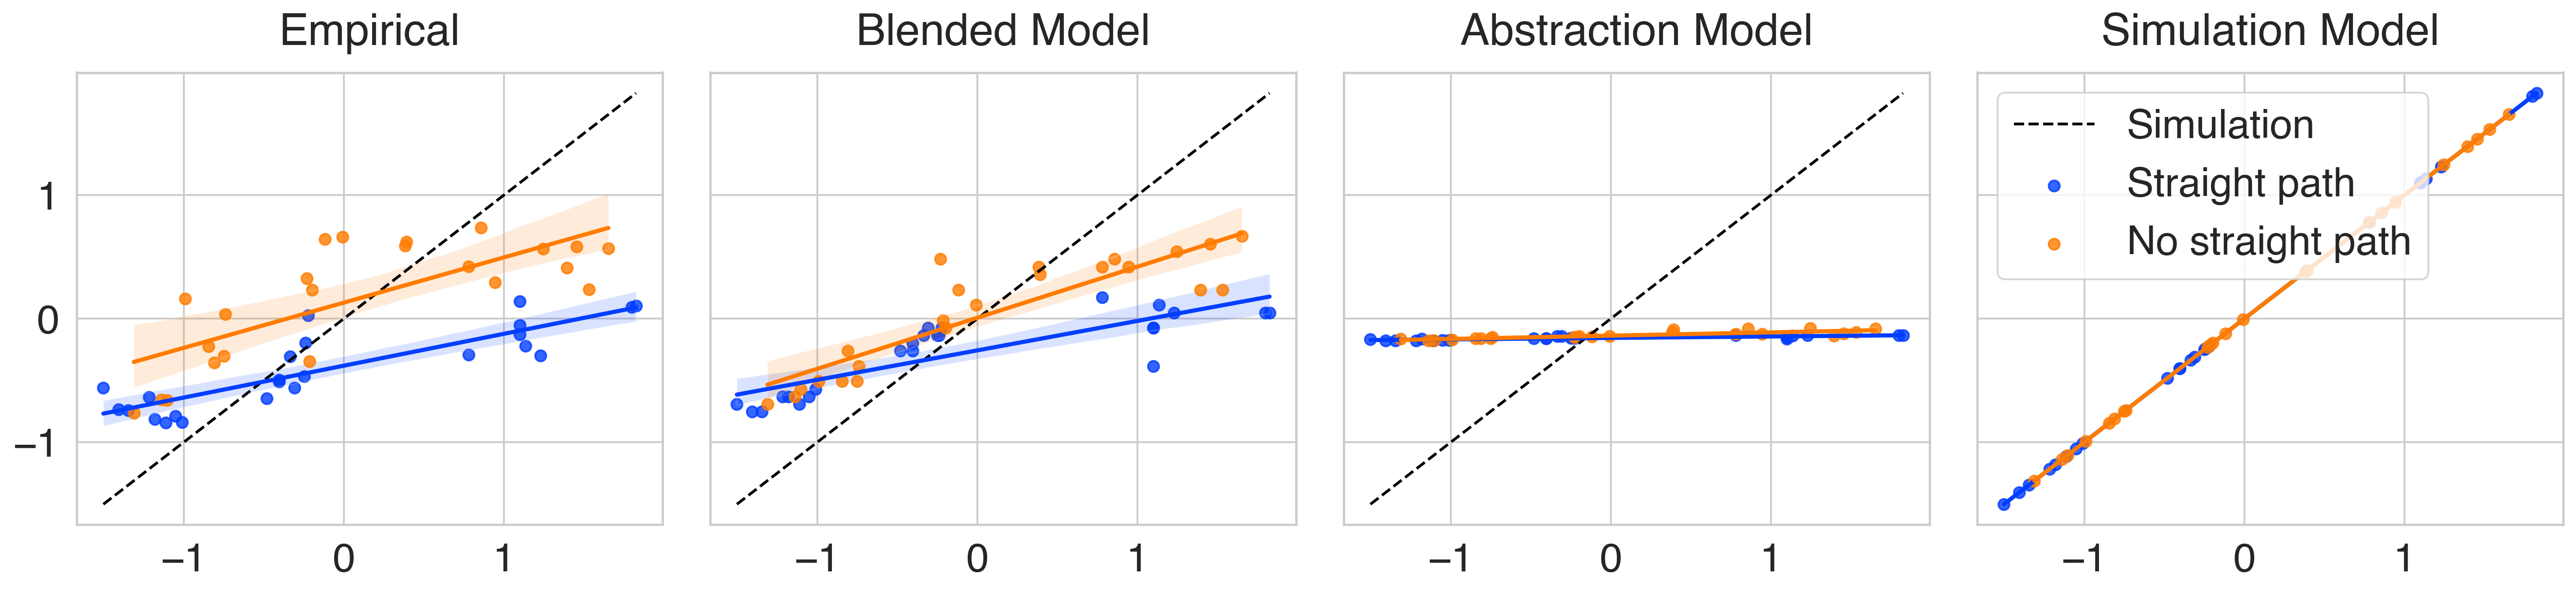

In [189]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols=4, sharey=True, sharex=True)
# sns.set(rc={'figure.figsize':(5,2)})
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=2,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
        'figure.figsize':(20,5),
    },
)

x = np.linspace(
    min(mean_rt.mean_rt_z_simulation),
    max(mean_rt.mean_rt_z_simulation)
)
ax1.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
ax2.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
ax3.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
ax4.plot(x, 
        x, 
        linestyle='dashed',
        label='Simulation',
        color='Black',
       )
# Empirical
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_empirical', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax1
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_empirical',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax1
           )
# Blended
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_blended_fit', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax2
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_blended_fit',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax2
           )
# Abstraction
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_abstraction', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax3
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_abstraction',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax3
           )
# Simulation
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_simulation', 
            data=mean_rt[mean_rt.path_condition == 'straight'], 
            label="Straight path",
            ax=ax4
           )
sns.regplot(x='mean_rt_z_simulation',
            y='mean_rt_z_simulation',
            data=mean_rt[mean_rt.path_condition == 'not_straight'],
            label="No straight path",
            ax=ax4
           )
# ax1.set(ylim=(-2.1,2.1),xlim=(-3.1,3.1))
ax1.set_title('Empirical', pad=15)
ax2.set_title('Blended Model', pad=15)
ax3.set_title('Abstraction Model', pad=15)
ax4.set_title('Simulation Model', pad=15)
ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')
ax1.set_ylabel('')
ax2.set_ylabel('')
ax3.set_ylabel('')
ax4.set_ylabel('')
plt.tight_layout()
plt.legend()
if True:
    plt.savefig(f'{figure_dir}/exp1_results_panel.pdf')

In [138]:
num_observations = len(mean_rt)


In [139]:
mse_empirical_blended = np.mean((mean_rt['mean_rt_z_empirical'] - mean_rt['mean_rt_z_blended_fit'])**2)
mse_empirical_simulation = np.mean((mean_rt['mean_rt_z_empirical'] - mean_rt['mean_rt_z_simulation'])**2)
mse_empirical_abstraction = np.mean((mean_rt['mean_rt_z_empirical'] - mean_rt['mean_rt_z_abstraction'])**2)

In [176]:
print(f'MSE of Blended Model predictions: {mse_empirical_blended}')
print(f'MSE of Abstraction Model predictions: {mse_empirical_abstraction}')
print(f'MSE of Simulation Model predictions: {mse_empirical_simulation}')

MSE of Blended Model predictions: 0.06973371678615611
MSE of Abstraction Model predictions: 0.21992229716417275
MSE of Simulation Model predictions: 0.6006823096510037


In [179]:
log_mle_blended = -num_observations/2 * (np.log(2*np.pi * mse_empirical_blended) + 1)
log_mle_simulation = -num_observations/2 * (np.log(2*np.pi * mse_empirical_simulation) + 1)
log_mle_abstraction = -num_observations/2 * (np.log(2*np.pi * mse_empirical_abstraction) + 1)

In [182]:
mle_blended = np.e**log_mle_blended
mle_abstraction = np.e**log_mle_abstraction
mle_simulation = np.e**log_mle_simulation

In [183]:
print(f'MLE of Blended Model predictions: {mle_blended}')
print(f'MLE of Abstraction Model predictions: {mle_abstraction}')
print(f'MLE of Simulation Model predictions: {mle_simulation}')

MLE of Blended Model predictions: 0.01644169734531445
MLE of Abstraction Model predictions: 3.1154808299401356e-14
MLE of Simulation Model predictions: 1.732602682083229e-24


In [184]:
# BIC
blended_bic = 3*np.log(num_observations) - 2*np.log(mle_blended)
abstraction_bic = 3*np.log(num_observations) - 2*np.log(mle_abstraction)
simulation_bic = 3*np.log(num_observations) - 2*np.log(mle_simulation)

In [185]:
print(f'BIC of Blended Model: {blended_bic}')
print(f'BIC of Abstraction Model: {abstraction_bic}')
print(f'BIC of Simulation Model: {simulation_bic}')

BIC of Blended Model: 19.766312104799525
BIC of Abstraction Model: 73.75005840924635
BIC of Simulation Model: 120.97527783187769


In [70]:
from pymer4.models import Lmer

In [74]:
formula = 'participant_z_rt ~ mean_rt_z_simulation + path_condition + mean_rt_z_simulation*path_condition + (mean_rt_z_simulation + path_condition + mean_rt_z_simulation*path_condition | subject_id)'

In [75]:
model = Lmer(formula, data=full_rt)

model.fit()

boundary (singular) fit: see help('isSingular') 

Linear mixed model fit by REML [’lmerMod’]
Formula: participant_z_rt~mean_rt_z_simulation+path_condition+mean_rt_z_simulation*path_condition+(mean_rt_z_simulation+path_condition+mean_rt_z_simulation*path_condition|subject_id)

Family: gaussian	 Inference: parametric

Number of observations: 2151	 Groups: {'subject_id': 47.0}

Log-likelihood: -1980.259 	 AIC: 3990.517

Random effects:

                                                   Name    Var    Std
subject_id                                  (Intercept)  0.000  0.000
subject_id                         mean_rt_z_simulation  0.015  0.122
subject_id                       path_conditionstraight  0.002  0.050
subject_id  mean_rt_z_simulation:path_conditionstraight  0.022  0.149
Residual                                                 0.356  0.597

                               IV1  \
subject_id             (Intercept)   
subject_id             (Intercept)   
subject_id             (Int

,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),0.119,0.083,0.155,0.019,2041.331,6.409,0.000,***
mean_rt_z_simulation,0.371,0.319,0.423,0.027,50.119,13.915,0.000,***
path_conditionstraight,-0.500,-0.553,-0.448,0.027,203.406,-18.638,0.000,***
mean_rt_z_simulation:path_conditionstraight,-0.113,-0.180,-0.046,0.034,46.705,-3.322,0.002,**
